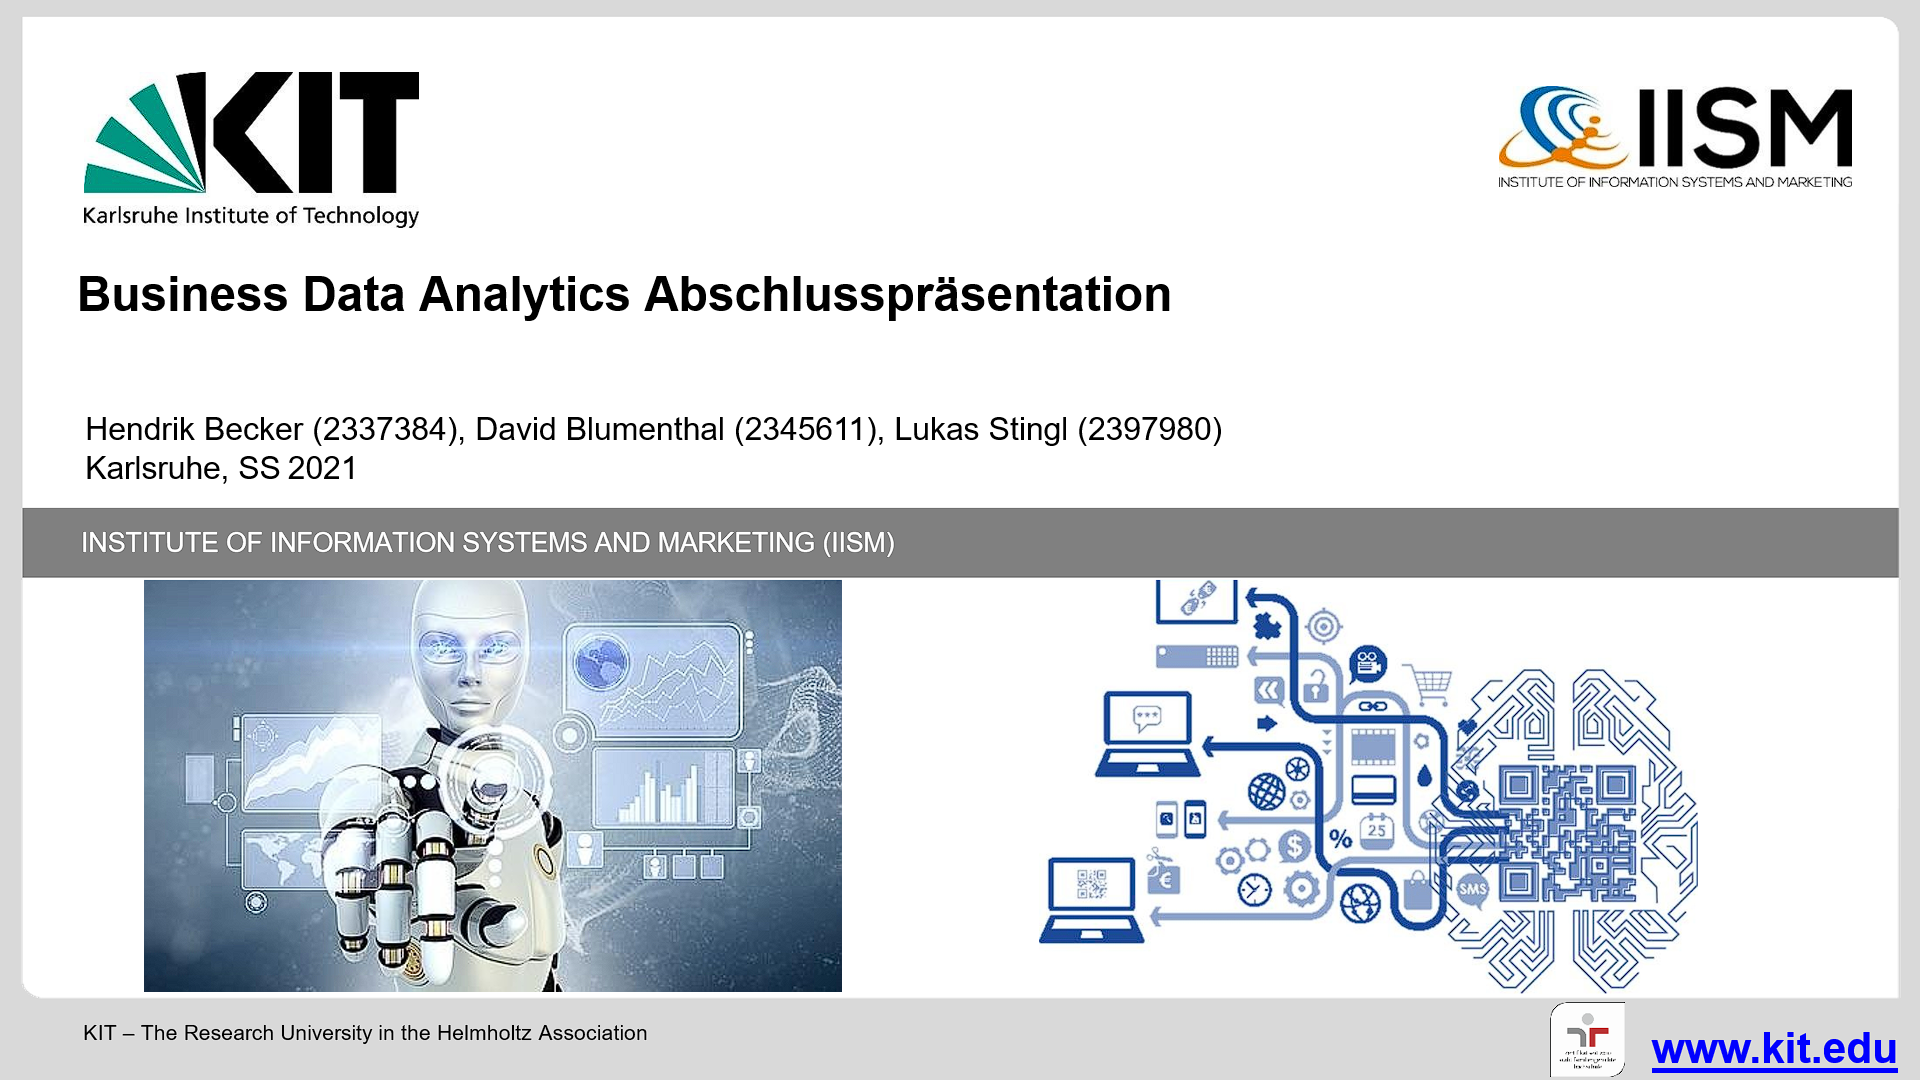

# Abschlusspräsentation Business Data Analytics 2021
## Gliederung

### 1. Business Understanding
### 2. Data Understanding 
### 3. Data Preperation 
### 4. Modeling 
### 5. Evaluation 
### 6. Ausblick


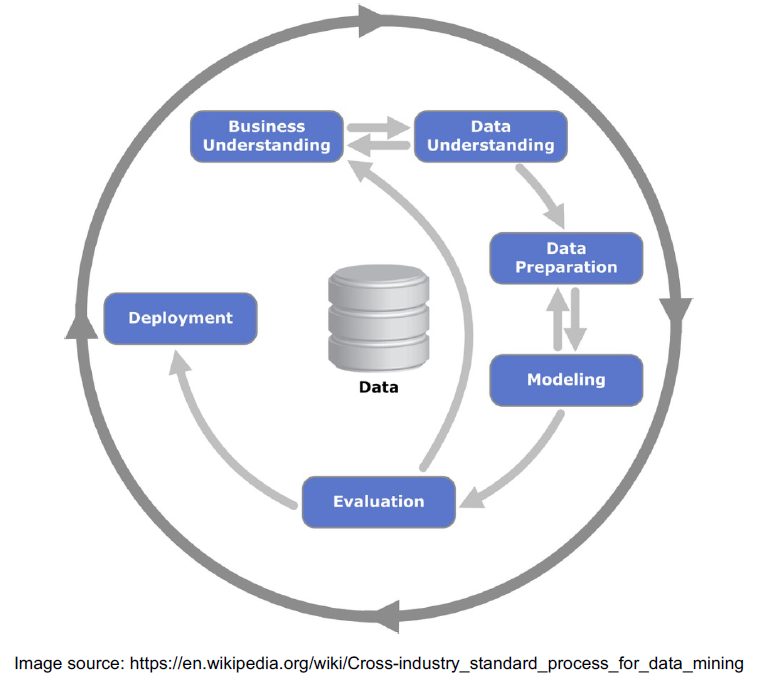

Wir orientieren uns innerhalb der Präsentation am CRISP-DM Modell. Diesen Ansatz haben wir auch innerhalb des Projektes verfolgt.

## 1 Business Understanding
* Frankfurter Entsorgungs- und Service GmbH 72 Glascontainern in Frankfurt mit Sensorik ausgestattet
* In der Erkundungsphase → Ansätze für die Erschließung neuer Geschäftsfelder 
* Bisher lediglich die Daten Erfassung
* Leerung unabhängig vom Füllstand
* Ziel:  bedarfsgerechte und datenbasierte Entsorgung. Langfristi: optimierte Routenplanung




* Zeitraum: 08.05.2020 - 08.05.2021 
* Potentielles Risiko für das Projekt: häufig vorkommende Messfehlern
* und keine vollständigen Füll- und Leerungszyklen 


## 2 Data Understanding

### Vorgehen

*   Parsen der Daten von JSON in csv Format 
*   Füllstände für jeden Conatiner visualisieren 
*   Weitere Daten hinzuziehen
*   Korrelation zwischen featuren überprüfen











#### Parsen der Daten



*   nur die wichtigsten Daten werden in das csv Format übernommen 
*   durch das Abspeichern in csv Dateien lassen sich die Daten einfach in DataFrames importieren  
*   für jeden Container erstellen wir eine eigene csv Datei




#### Füllstände visualisieren

*   als erster Schritt in der Datenanalyse werden die Füllstände für jeden 	Container visualisiert 
*   im Folgenden zwei Beispiele:





Füllstände.png

#### Weitere Daten 

*   weiterhin werden zusätzliche features hinzugefügt
*   dabei haben wir folgende Daten in Betracht gezogen: 

1.   Feiertage 

     *   Feiertage werden mit 0 und 1 kodiert
     *   0 = kein Feiertag in Hessen, 1 = Feiertag in Hessen 
     *   die Hypothese: an Feiertagen ist das Füllverhalten anders als an normalen Tagen   

2.   Wetterdaten

     *   Wetterdaten aus Frankfurt werden für den gegebenen Zeitraum hinzugefügt
     *   wir haben für jeden Tag Informationen über die Temperatur, den Niederschlag und weitere Werte 
     *   auch hier gehen wir davon aus, dass eine Korrelation zum Füllstand bestehen könnte 

3.   Daten über Fußballspiele / andere Großveranstaltungen 

     * zuletzt erachten wir Großveranstaltungen in der Stadt Frankfurt als einflussreich auf den Füllstand
     * leider stammen die Daten zu den Füllständen aus der Zeit der Corona-Pandemie, wo kaum Großveranstaltungen durchgeführt wurden 
     * wir konnten zu diesem Punkt leider keine Daten erheben







#### Korrelationen

*   bevor ein Modell auf den gebenen Daten trainiert werden kann, untersuchen wir, welche Daten sich als feature anbieten 
*   zu diesem Zweck analysieren wir Korrelationen zwischen den Daten



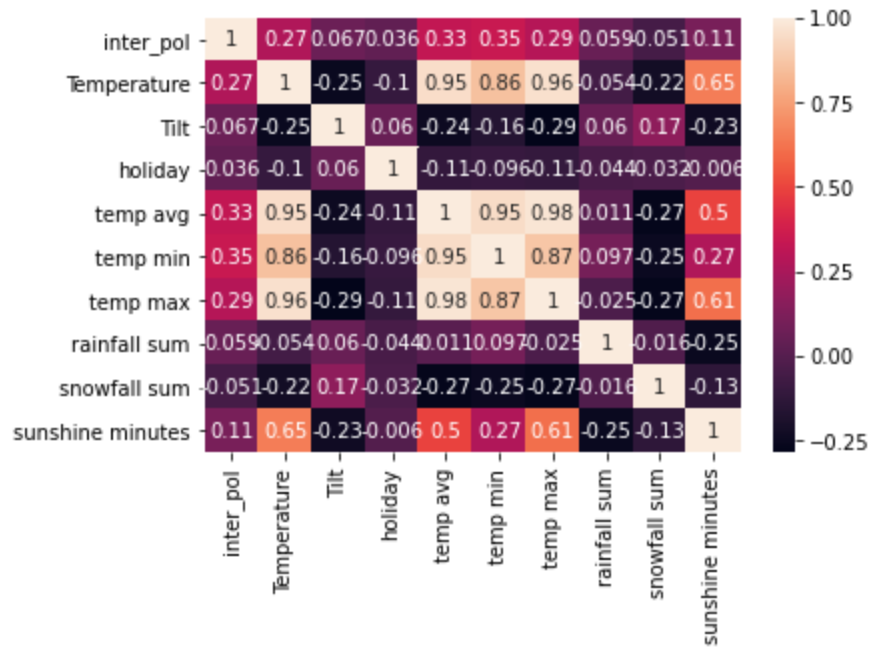


*   in der angegebenen Heatmap wurden die Korrelationen zwischen den einzelnen featuren berechnet
*   wir nutzen dafür den Füülstand (inter_pol), die Container-Daten (Container Temperatur, Tilt), den Feiertag Wert und einige Wetterdaten (Temperatur, Niederschlag und Sonnenschein Minuten)
*   das Ergebnis ist allerdings eine niedrige Korrelation für alle features. 
*   am besten korrelieren die Wetterdaten mit dem Füllstand, doch auch hier ist die Korrelation nicht sehr groß

=> wir entschließen uns auf Basis dieser Analyse dazu, die features nicht in unsere Modelle einzubeziehen, sondern ein Modell nur auf Basis der Füllstände zu entwickeln. 



## Data Preparation

* Daten kommen von EDGE Geräten -> eher ungenau mit Noise
* Daten enthalten viele Messfehler und fehlende Werte




* Da die Daten durch EDGE Devices generiert wurden enthalten diese Noise
* Sowie Messfehler und fehlende Werte

### Daten Auswahl

*   nachdem die Füllstände für den gesamten Zeitraum von allen Container visualisiert wurden, werden unbrauchbare Daten ausgeschlossen
*   das obere Bild zeigt Daten, die wir in der Folge verwenden 
*   das untere Bild zeigt Daten, die wir ausschließen
*   wir sehen uns auf diese Weise alle Container an und schließen die Container aus, die unsaubere Daten angeben
*   unsauber sind in diesem Fall zu große Schwankungen des Füllstandes in einem kurzen Zeitintervall

![brauchbar](./presentation_ressources/brauchbar.png)
![unbrauchbar](./presentation_ressources/unbrauchbar.png)

### Cleaning and Smoothing


Da die Ergebnisse der Modellierung von der Qualität der Daten abhängen gilt es, eben genannte Datenunreinheiten zu beseitigen

Offensichtliche Messfehler entfernen

```python
new = new[new.Height < 190]
new.loc[(new.Temperature > 100), 'Temperature'] = np.nan
```

Da die sehr Noisy sind und wir mehr am Trend interessiert sind haben wir unterschiedliche Smooting verfahren angewandt

```python
#moving average smoothing
df['mov_avg'] = df['Height'].rolling(30).mean()
```

![/Screenshot_2021-07-24_at_03.46.27.png](./presentation_ressources/plot.png)

### Transformation

Erste Modellierungsversuche zeigten, die Daten sind noch zu granular
→ Aggregation auf Tagesniveau

- Gruppieren mithilfe des avg() Operators
- Fehlende Werte wurden mithilfe von Interpolationsmethoden aufgefüllt

Ähnlichkeiten im Verlauf der Zeitreihen —> Unsupervised Learning Approach - Clustering

Mithilfe von Dynamic Time Warping und K-means konnten haben sich drei Cluster herauskristallisiert

![/clusters.png](presentation_ressources/clusters.png)

Mithilfe der Container Standorte visualisierten wir die Cluster auf einer Karte in der Hoffnung ein Muster zu erkennen 

![/Screenshot_2021-07-24_at_04.05.14.png](./presentation_ressources/map.png)

## 4 Modeling

Im Folgenden gehen wir auf unsere unterschiedlichen Modelle ein. Dafür müssen zunächst einige Annahmen getroffen werden: 

*   wie bereits in Kapitel 2 angegeben nutzen wir nur die Füllstand Daten für die Modelle. Der Füllstand ist somit feature und target zugleich
*   es soll ein Modell entwickelt werden, welches den Füllstand für den nächsten Zeitpunkt bestimmen kann, auf Basis der letzten Füllstände

*   Was ist unser Ziel? 

Unser Ziel ist es nicht die Kurve des Füllstandes für einen Container möglichst genau vorhersagen zu können. Dies würde aus unserer Sicht keinen Wert generieren, da wir auf Basis der gegebenen Füllstände nicht den optimalen Zeitpunkt einer Leerung entnehmen können. 

* Der Grund: 

Die Container wurden in der Vergangenheit nicht geleert wenn sie voll waren, sondern in nicht definierten Intervallen. Wir wollen ermöglichen vorhersagen zu können, wann ein Container voll ist und geleert werden muss. 


Im Folgenden erläutern wir folgende Modelle: 

1.   Lineare Regression 
2.   LSTM





### 1. Lineare Regression
#### Cluster 0:
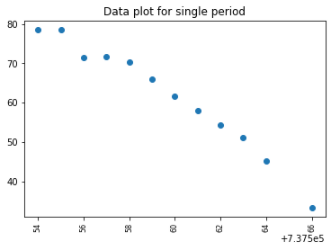


* Zunächst beispielhaftes Füllintervall herausgesucht
* Darauf basierend Test- und Trainingsdatensätze abgeleitet und lineare Regression angewandt
* Annahme: Steigung über ganzes Cluster ähnlich

##### Steigung: -3.6226
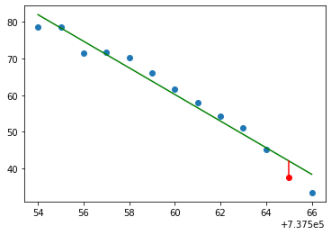

### Cluster 1
##### Steigung: -3.6304
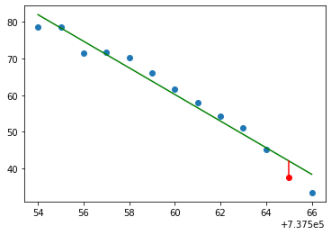


### Cluster 2
##### Steigung: -3.3883
image.png


* Im weiteren Verlauf Leerungszeitpunkte ermittelt und die Regression zwischen jeweils zwei Leerungszeitpunkte gelegt

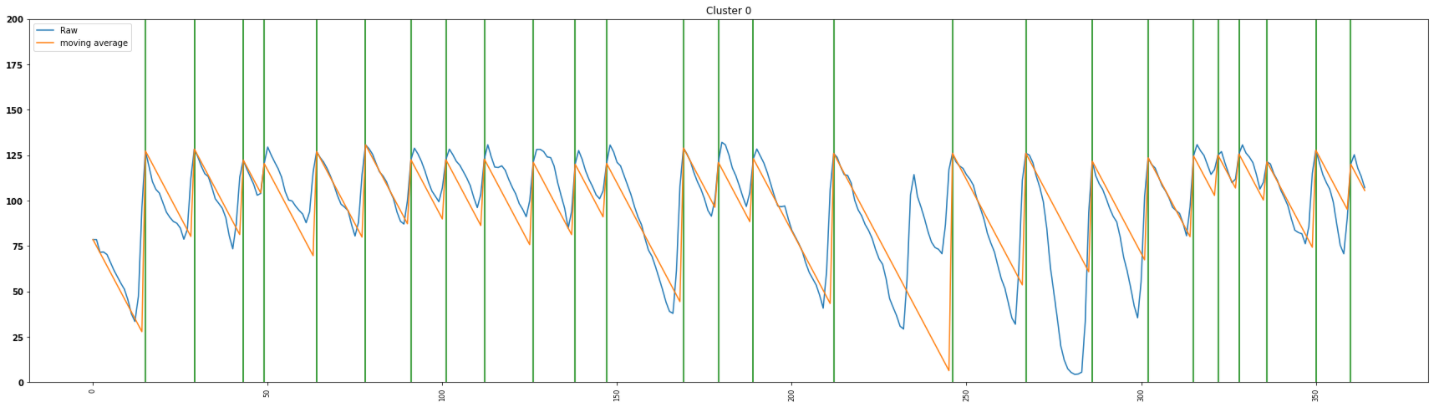
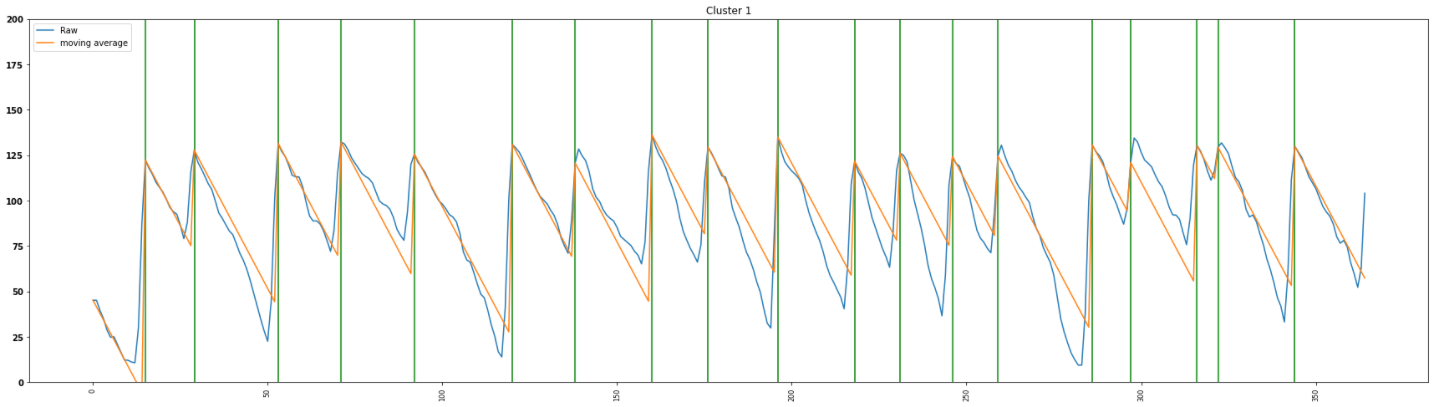
image.png


### 2. LSTM

Für das LSTM haben wir drei Unterschiedliche Ansätze verfolgt: 

1.   LSTM auf Basis eines Clusters mit Daten für jede Stunde 
2.   LSTM auf Basis aller Cluster mit Daten für jede Stunde 
3.   LSTM auf Basis aller Cluster mit Daten für jeden Tag


* Generell wenden wir einen Timeseries Generator an, der uns Zeitfenster aus den gegebenen Daten mit einer bestimmten Länge und einer prozentualen Überschneidung ausschneidet
* Auf diese Weise erhalten wir unsere Datensätze, die dann mithilfe der train-test-split Metode in ein Trainings-/Test- und Evaluationsset aufgeteilt werden
* Unsere Modell Architektur ist unten beschrieben. Wir verwenden zwei LSTM und einen output-layer. 
* Unsere Input Daten werden nicht skaliert, wir verwenden nur ein einziges feature (den Füllstand)



Im Folgenden werden wir die Ergebnisse präsentieren: 



1.   LSTM auf Basis eines Clusters mit Daten für jede Stunde 


*   Im ersten Anlauf nehmen wir die Daten eines Clusters und trainieren ein LSTM auf den Füllstand Daten für jede Stunde
*   Eine Input Sequenz hat dabei eine Länge von 40 Stunden, also 40 Datenpunkte
* Das Training sieht wie folgt aus: 


Training_LSTM_c0.png


   *   Wie aus dem Training entnommen werden kann, sinkt der MAE, welcher für die Evaluierung verwendet wird, mit den Epochen ab.

   * im nächsten Schritt geben wir eine Test Sequenz, die das Modell noch nicht kennt als Input und lassen iterativ die nächsten 500 Werte vorhersagen 



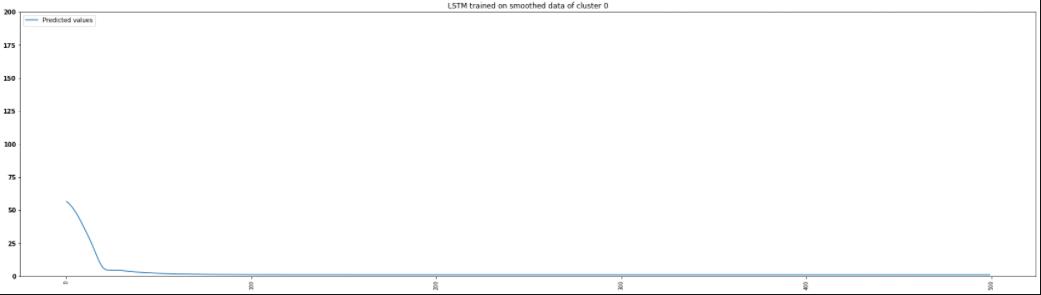

     
   *   aus der Abbildung kann entnommen werden, das das LSTM die Steigung gelernt hat, jedoch nicht die Leerungen
   *   unser Ziel ist es nicht die Leerungen vorherzusagen, sondern den Zeitpunkt vorherzusagen, an dem der Container voll ist 
   *   in der Folge setzen wir den Wert des Füllstandes auf 140 zurück (was einen leeren Container imitieren soll) und lassen das Modell erneut die nächsten Werte bestimmen



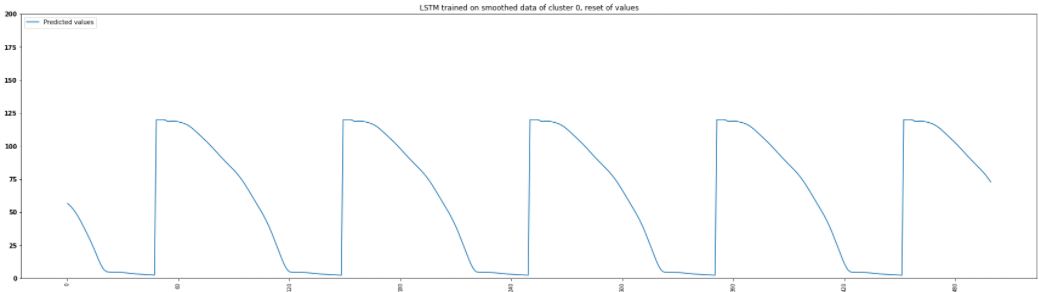


  *   Es ergibt sich die oben sichtbare Vorhersage. Wir evaluieren nun an einem gesamten Container Datensatz, ob diese Vorhersage Sinn ergibt:



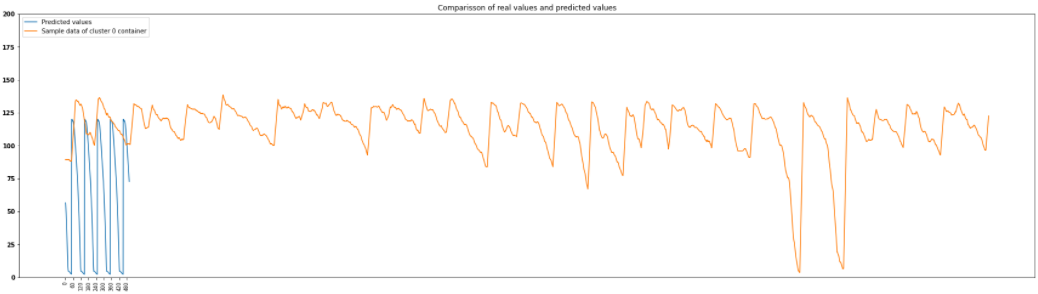

 
  *   Leider ergibt sich aus dem oben sichtbaren Graphen, dass die Vorhersage nicht passend ist
  *   Das Modell hat zwar den MAE minimiert, scheint aber die Veränderungen des Füllstandes nicht gelernt zu haben



2.   LSTM auf Basis aller Cluster mit Daten für jede Stunde 

  *   Als nächstes wurde dieselbe Modell Architektur wie in 1. verwendet und die Sequenzlänge auf 50 Datenpunkte erhöht
  *   Das Training minimiert erneut den MAE, aber das Ergebnis sieht wie in 1. aus.





3.   LSTM auf Basis aller Cluster mit Daten für jeden Tag

   *   da die bisherigen Versuche kein passendes Ergebnis lieferten, wurde gemäß dem Crisp-DM Modell die Datengrundlage angepasst
   *   diesmal werden alle Daten betrachtet, aber gruppiert für einen ganzen Tag
   * demnach gibt es für jeden Container nur ca. 365 Datenpunkte

   * aufgrund dieser Datenreduzierung wurde auch die Länge der Input Sequenz verkürzt, auf 10 Datenpunkte/Tage pro Input-Sequenz

   * das Training des Modells sah folgendermaßen aus:






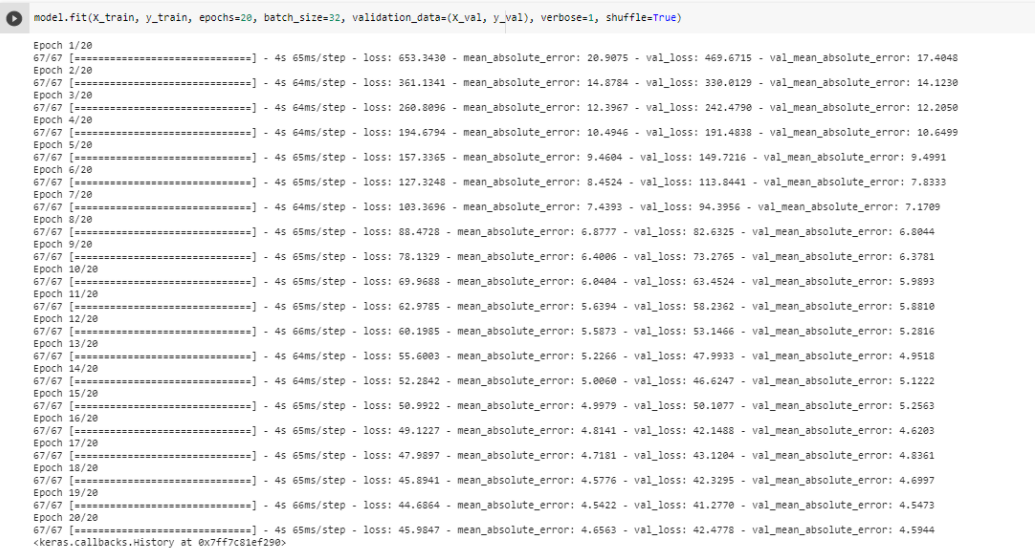

  
  *   auch hier lässt sich erkennen, das der MAE minimiert wird und konvergiert
  *   im Folgenden lassen wir 300 Werte vorhersagen, wobei wir erneut den Füllstand auf 140 zurücksetzen, sobald die Vorhersage für den nächsten Tag nicht mehr geringer wird



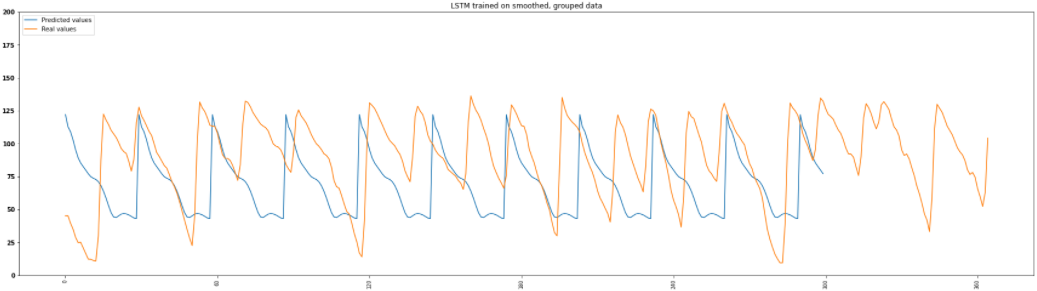


   *   es ergibt sich die oben angegebene Vorhersage.
   *   es lässt sich erkennen, dass die Vorersage ein ähnliches Gefälle hat, wie der Beispiel Container.
   * wir berechnen als nächstes die Steigung 



##### Steigung: -4,1997

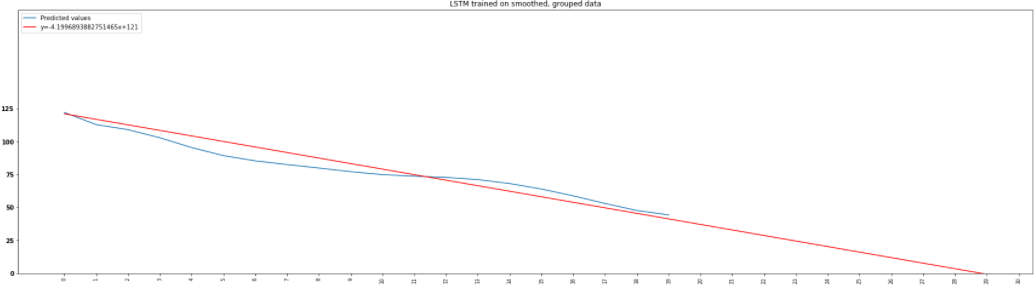


   *   gemäß der Vorhersage unseres Modells ergibt sich die oben sichtbare Steigung
   *   diese lineare Funktion schneidet die x-Achse bei ca. 29
   * somit sollte der Container nach 29 Tagen vollständig gefüllt sein und geleert werden



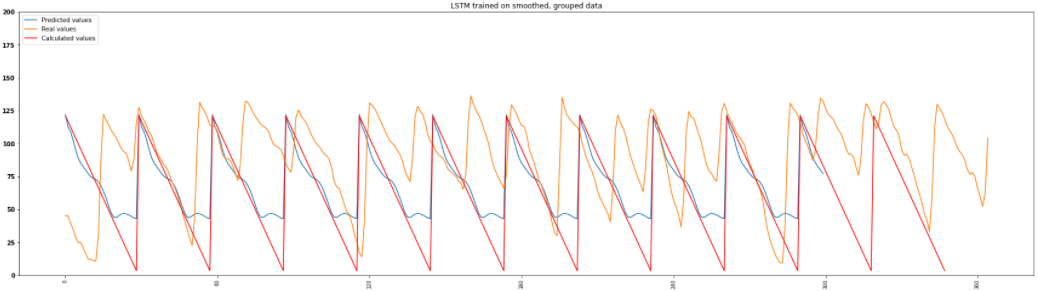


   *   der rote Graph gibt ein optimales Leerungsverhalten an
   * demnach wird der Container ca. alle 29 Tage geleert



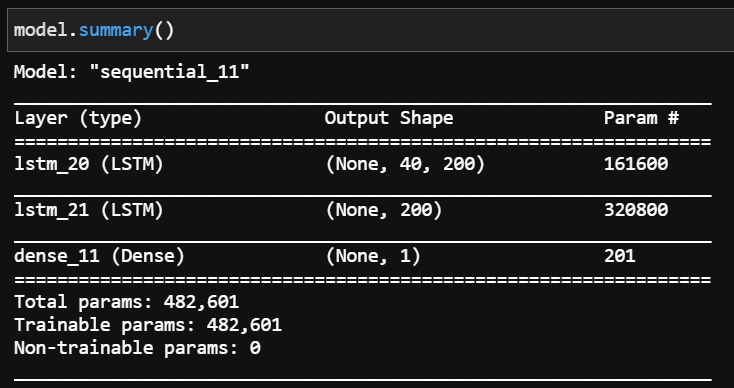


  *   zuletzt ist hier eine Modell Architektur angegeben. Wir verwenden diese Architektur für alle 3 LSTM Modelle bzw. Studien
  * einzig die Länge der Input-Sequenz ist variabel wie bereits erwähnt


# 5 Evaluation

#### Zum LSTM Modell

*   wie in 4. beschrieben ist unser LSTM mit gruppierten Daten in der Lage ein Füllverhalten für alle Container zusammen anzugeben
*   wir berechnen dabei die Steigung manuell und berechnen, wann der durchschnittliche Container voll ist 
*   während des Trainings schaffen wir es, den MAE konvergieren zu lassen



* Probleme: 



* leider können wir den Gleichen Ansatz nicht für die einzelnen Cluster verwenden, da zu wenig Daten vorhanden sind
* in diesen Fällen wird der MAE nicht minimert 
* für die Hyperparameter wurden viele Studien durchgeführt
* das verwendete Modell hat den MAE am besten minimiert







### Fazit 
*  wir schaffen es mit einem naiven Ansatz über eine lineare Regression die Steigung des Füllverhaltens für einen einzelnen Container zu berechnen
* so können wir für jeden Container optimale Füllintervalle bestimmen 
* unser LSTM schafft es ebenfalls die Steigung der Füllintervalle zu lernen
* für den LSTM Ansatz sind zu wenig Daten vorhanden, um ein Modell für einen einzelnen Container oder einzelne Cluster zu entwerfen



# 6 Ausblick
* Daten guter Indikator für zukünftige Füllungen
* Optimierungspotenzial vorhanden
* Container erst leeren, wenn gewünschter Füllstand erreicht
* Container Standorte berücksichtigen (mittels LoRaWAN GPS Sensor)
* Corona bedingter Ausfall von Veranstaltungen
 

# Vielen Dank für die Aufmerksamkeit